## Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

## Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.
2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.
3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [1]:
# Importing the necessary libraries

import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [2]:
# set the seed for reproducability
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# importing some other libraries which will be needed for model building.

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout

In [5]:
# Location of the train and test data, project_folder, it should be same directory as the script
#project_folder='/home/datasets/Project_data'
current_dir = os.getcwd()
project_folder = os.path.join(current_dir,"Project_data")

In [6]:
# function to plot accuracies and losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    # initialisng the path for project data
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    # initialising the image attributes    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
        
    # initialising the batch_size, frames_to_sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
                (image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model Building
Model section where we build the try different experiments. We are using `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. Also using `TimeDistributed` while building a Conv2D + RNN model. The last layer is the softmax. We designed the network in such a way that the model is able to give good accuracy.

## Simple Model

In [8]:
class Conv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
conv_3d1=Conv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 80, 80, 32)    1

##### Sample Cropping

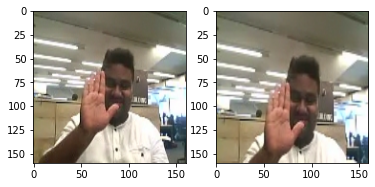

In [10]:
test_generator=Conv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

#### Experimenting with Image resolution, number of frames to use and batch_size

##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [15]:
conv_3d1=Conv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
34/34 [==============================] - ETA: 0s - loss: 1.6437 - categorical_accuracy: 0.3741
Epoch 00001: val_loss improved from inf to 1.86462, saving model to model_init_2021-06-2804_17_13.123633/model-00001-1.64370-0.37406-1.86462-0.21000.h5
34/34 [==============================] - 145s 4s/step - loss: 1.6437 - categorical_accuracy: 0.3741 - val_loss: 1.8646 - val_categorical_accuracy: 0.2100
Epoch 2/2
34/34 [==============================] - ETA: 0s - loss: 1.1743 - categorical_accuracy: 0.5400
Epoch 00002: val_loss did not improve from 1.86462
34/34 [==============================] - 149s 4s/step - loss: 1.1743 - categorical_accuracy: 0.5400 - val_loss: 3.5205 - val_categorical_accuracy: 0.2100


In [16]:
conv_3d1=Conv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.5895 - categorical_accuracy: 0.4299
Epoch 00001: val_loss improved from inf to 2.60004, saving model to model_init_2021-06-2804_22_15.550324/model-00001-1.58945-0.42986-2.60004-0.21000.h5
45/45 [==============================] - 171s 4s/step - loss: 1.5895 - categorical_accuracy: 0.4299 - val_loss: 2.6000 - val_categorical_accuracy: 0.2100
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.0315 - categorical_accuracy: 0.6214
Epoch 00002: val_loss did not improve from 2.60004
45/45 [==============================] - 170s 4s/step - loss: 1.0315 - categorical_accuracy: 0.6214 - val_loss: 3.6815 - val_categorical_accuracy: 0.2200


In [17]:
conv_3d1=Conv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.5268 - categorical_accuracy: 0.4540
Epoch 00001: val_loss improved from inf to 3.21810, saving model to model_init_2021-06-2804_28_02.112778/model-00001-1.52683-0.45400-3.21810-0.21000.h5
23/23 [==============================] - 92s 4s/step - loss: 1.5268 - categorical_accuracy: 0.4540 - val_loss: 3.2181 - val_categorical_accuracy: 0.2100
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 0.9784 - categorical_accuracy: 0.6290
Epoch 00002: val_loss did not improve from 3.21810
23/23 [==============================] - 92s 4s/step - loss: 0.9784 - categorical_accuracy: 0.6290 - val_loss: 6.8883 - val_categorical_accuracy: 0.2400


- As we see from the above experiments **"image resolution"** and **number of frames** in sequence have more impact on training time than **batch_size**
- We can consider the Batch Size around 15-30
- We will change the resoulution 160*160 according the model performance


## Model No. 1
#### Base Model 
- Batch Size = 40 
- No. of Epochs = 10

In [18]:
class Conv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
conv_3d1=Conv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=10)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_20 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_21 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 10, 80, 80, 32)   

In [20]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 1.5935 - categorical_accuracy: 0.4268
Epoch 00001: val_loss improved from inf to 1.58814, saving model to model_init_2021-06-2804_32_12.685441/model-00001-1.59354-0.42685-1.58814-0.25000.h5
17/17 [==============================] - 118s 7s/step - loss: 1.5935 - categorical_accuracy: 0.4268 - val_loss: 1.5881 - val_categorical_accuracy: 0.2500
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 1.0345 - categorical_accuracy: 0.5928
Epoch 00002: val_loss did not improve from 1.58814
17/17 [==============================] - 115s 7s/step - loss: 1.0345 - categorical_accuracy: 0.5928 - val_loss: 2.2368 - val_categorical_accuracy: 0.2200
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 0.6783 - categorical_accuracy: 0.7451
Epoch 00003: val_loss did not improve from 1.58814
17/17 [==============================] - 113s 7s/step - loss: 0.6783 - categorical_accuracy: 0.745

## Model No. 2  
#### Same architecture but adding dropout layers 
- Batch Size = 20 
- No. of Epochs = 15

In [21]:
conv_3d2=Conv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=15)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_24 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_25 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 10, 80, 80, 32)   

In [22]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.8487 - categorical_accuracy: 0.4118
Epoch 00001: val_loss improved from inf to 3.48669, saving model to model_init_2021-06-2804_53_40.691427/model-00001-1.84867-0.41176-3.48669-0.16000.h5
34/34 [==============================] - 228s 7s/step - loss: 1.8487 - categorical_accuracy: 0.4118 - val_loss: 3.4867 - val_categorical_accuracy: 0.1600
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.4093 - categorical_accuracy: 0.5128
Epoch 00002: val_loss did not improve from 3.48669
34/34 [==============================] - 231s 7s/step - loss: 1.4093 - categorical_accuracy: 0.5128 - val_loss: 4.2597 - val_categorical_accuracy: 0.1600
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.2430 - categorical_accuracy: 0.5573
Epoch 00003: val_loss did not improve from 3.48669
34/34 [==============================] - 226s 7s/step - loss: 1.2430 - categorical_accuracy: 0.557

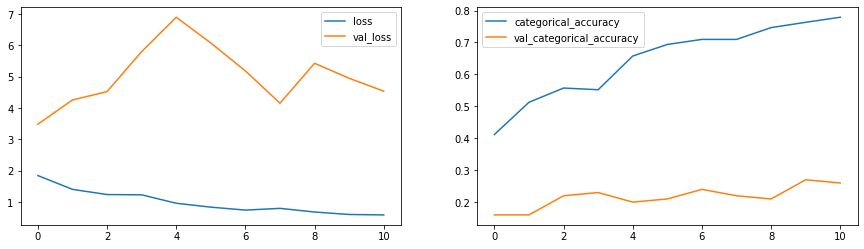

In [23]:
plot(history_model2)

##### We can see  val_loss did not improve from 3.48669 so earlystopping stops the epoch automatically!! 
- Last Epoch stop on 11/15!! 
- Overall early stopping is working as expected
- Best weights save automatically. The validation accuracy of 26% and training accuracy of 77%. 
- The numbers shows that the model is overfitting. 

We will try to reduce the filter size and image resolution and observe the results. 
Let's try lowering the learning rate to 0.0002

## Model No. 3 

- Reduce filter size to (2,2,2) 
- image res to 120 x  120
- Batch Size = 30 
- No. of Epochs = 15

In [26]:
class Conv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [27]:
conv_3d3=Conv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=15)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_28 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_29 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 8, 60, 60, 32)    

In [28]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 2.1325 - categorical_accuracy: 0.3235
Epoch 00001: val_loss improved from inf to 1.93669, saving model to model_init_2021-06-2805_36_48.466846/model-00001-2.13246-0.32353-1.93669-0.21000.h5
23/23 [==============================] - 150s 7s/step - loss: 2.1325 - categorical_accuracy: 0.3235 - val_loss: 1.9367 - val_categorical_accuracy: 0.2100
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.4422 - categorical_accuracy: 0.5068
Epoch 00002: val_loss did not improve from 1.93669
23/23 [==============================] - 151s 7s/step - loss: 1.4422 - categorical_accuracy: 0.5068 - val_loss: 3.5326 - val_categorical_accuracy: 0.2000
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 1.2454 - categorical_accuracy: 0.5709
Epoch 00003: val_loss did not improve from 1.93669
23/23 [==============================] - 149s 6s/step - loss: 1.2454 - categorical_accuracy: 0.570

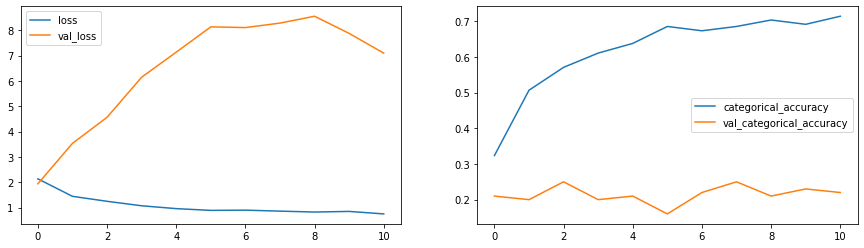

In [29]:
plot(history_model3)

Again we can see the sign of overfitting.
- Accuracy - 71%
- Validation accuracy - 22% 

## Model NO. 4  

#### Adding more layers 
- Batch Size = 20 
- No. of Epochs = 15

In [30]:
class Conv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [31]:
conv_3d4=Conv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_32 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_32 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_33 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 8, 60, 60, 16)    

In [32]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 2.0715 - categorical_accuracy: 0.3356
Epoch 00001: val_loss improved from inf to 2.24742, saving model to model_init_2021-06-2806_06_56.063415/model-00001-2.07154-0.33560-2.24742-0.21000.h5
34/34 [==============================] - 145s 4s/step - loss: 2.0715 - categorical_accuracy: 0.3356 - val_loss: 2.2474 - val_categorical_accuracy: 0.2100
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.6507 - categorical_accuracy: 0.4389
Epoch 00002: val_loss did not improve from 2.24742
34/34 [==============================] - 152s 4s/step - loss: 1.6507 - categorical_accuracy: 0.4389 - val_loss: 2.4123 - val_categorical_accuracy: 0.2600
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.4813 - categorical_accuracy: 0.4879
Epoch 00003: val_loss did not improve from 2.24742
34/34 [==============================] - 155s 5s/step - loss: 1.4813 - categorical_accuracy: 0.487

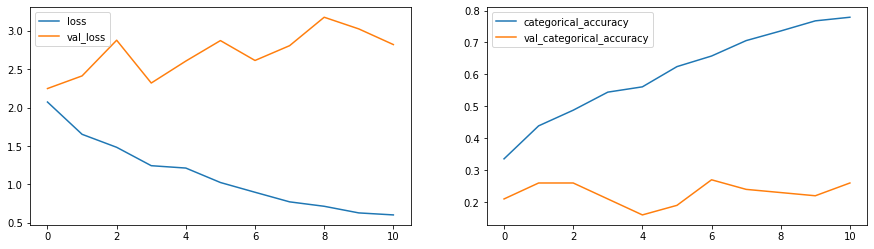

In [33]:
plot(history_model4)

With more layers we dont see much performance improvement. 
- Accuracy of 76%
- Validation Accuracy - 26% 

#### Let's try adding dropouts at the convolution layers

## Model NO. 5 
### Adding dropout at convolution layers

In [34]:
class Conv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [35]:
conv_3d5=Conv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_40 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_40 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_41 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_41 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 8, 60, 60, 16)    

In [36]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.9074 - categorical_accuracy: 0.3205
Epoch 00001: val_loss improved from inf to 2.15704, saving model to model_init_2021-06-2806_37_00.728603/model-00001-1.90743-0.32051-2.15704-0.20000.h5
34/34 [==============================] - 148s 4s/step - loss: 1.9074 - categorical_accuracy: 0.3205 - val_loss: 2.1570 - val_categorical_accuracy: 0.2000
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.3797 - categorical_accuracy: 0.4834
Epoch 00002: val_loss did not improve from 2.15704
34/34 [==============================] - 146s 4s/step - loss: 1.3797 - categorical_accuracy: 0.4834 - val_loss: 3.3730 - val_categorical_accuracy: 0.1300
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.1951 - categorical_accuracy: 0.5460
Epoch 00003: val_loss did not improve from 2.15704
34/34 [==============================] - 146s 4s/step - loss: 1.1951 - categorical_accuracy: 0.546

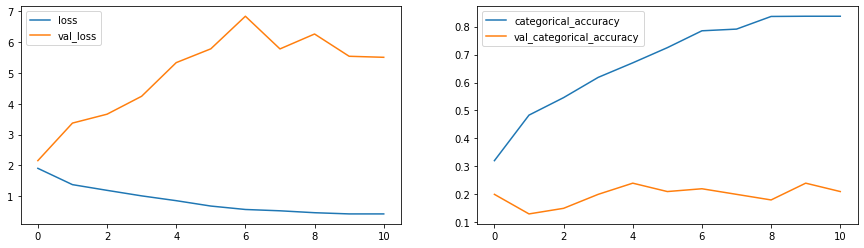

In [37]:
plot(history_model5)

Its Overfitting again!! Adding dropouts has further reduced validation accuracy also

#### Let's try to reduce the model size and see the performance

## Model No. 6 
####  Reducing the number of parameters

In [38]:
class Conv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [39]:
conv_3d6=Conv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_48 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_48 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_40 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_49 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_49 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 8, 50, 50, 32)   

In [40]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.8313 - categorical_accuracy: 0.3477
Epoch 00001: val_loss improved from inf to 1.79668, saving model to model_init_2021-06-2807_13_04.024167/model-00001-1.83134-0.34766-1.79668-0.21000.h5
34/34 [==============================] - 138s 4s/step - loss: 1.8313 - categorical_accuracy: 0.3477 - val_loss: 1.7967 - val_categorical_accuracy: 0.2100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2211 - categorical_accuracy: 0.5249
Epoch 00002: val_loss did not improve from 1.79668
34/34 [==============================] - 138s 4s/step - loss: 1.2211 - categorical_accuracy: 0.5249 - val_loss: 2.6696 - val_categorical_accuracy: 0.1800
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0694 - categorical_accuracy: 0.5920
Epoch 00003: val_loss did not improve from 1.79668
34/34 [==============================] - 140s 4s/step - loss: 1.0694 - categorical_accuracy: 0.5920

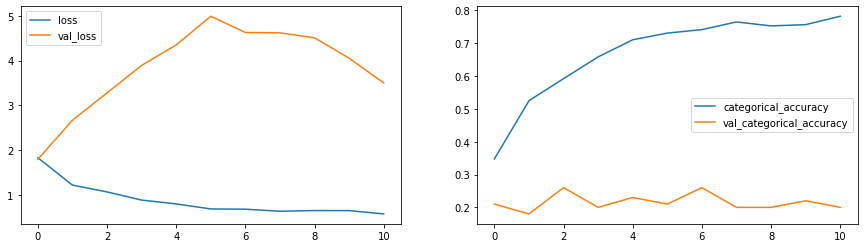

In [41]:
plot(history_model6)

There is not much improvement in our model. Overall same result. 

## Model No. 7 

#### Reducing the number of parameters again

In [12]:
class Conv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d7=Conv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_5 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 60, 60, 32)    

In [14]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6514 - categorical_accuracy: 0.4103
Epoch 00001: val_loss improved from inf to 1.99963, saving model to model_init_2021-06-2808_29_02.366824/model-00001-1.65143-0.41026-1.99963-0.16000.h5
34/34 [==============================] - 142s 4s/step - loss: 1.6514 - categorical_accuracy: 0.4103 - val_loss: 1.9996 - val_categorical_accuracy: 0.1600
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1112 - categorical_accuracy: 0.5732
Epoch 00002: val_loss did not improve from 1.99963
34/34 [==============================] - 145s 4s/step - loss: 1.1112 - categorical_accuracy: 0.5732 - val_loss: 2.7747 - val_categorical_accuracy: 0.1400
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9223 - categorical_accuracy: 0.6456
Epoch 00003: val_loss did not improve from 1.99963
34/34 [================

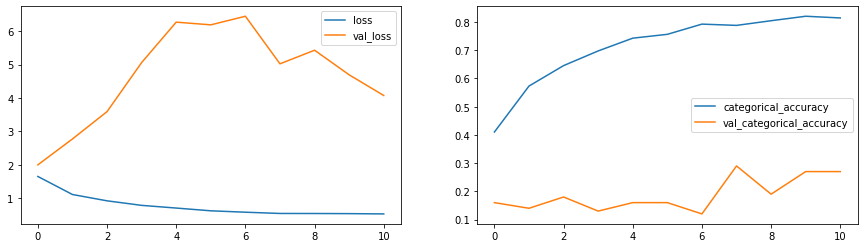

In [15]:
plot(history_model7)

Little improvement in Validation accuracy and Accuracy. 

## Model No. 8 

#### CNN- LSTM Model

In [16]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [17]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 64)   

In [18]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4333 - categorical_accuracy: 0.3763
Epoch 00001: val_loss improved from inf to 1.50234, saving model to model_init_2021-06-2808_57_05.750934/model-00001-1.43325-0.37632-1.50234-0.26000.h5
34/34 [==============================] - 160s 5s/step - loss: 1.4333 - categorical_accuracy: 0.3763 - val_loss: 1.5023 - val_categorical_accuracy: 0.2600
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0353 - categorical_accuracy: 0.5807
Epoch 00002: val_loss did not improve from 1.50234
34/34 [==============================] - 154s 5s/step - loss: 1.0353 - categorical_accuracy: 0.5807 - val_loss: 2.1782 - val_categorical_accuracy: 0.2300
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8785 - categorical_accuracy: 0.6486
Epoch 00003: val_loss did not improve from 1.50234
34/34 [==============================] - 152s 4s/step - loss: 0.8785 - categorical_accuracy: 0.648

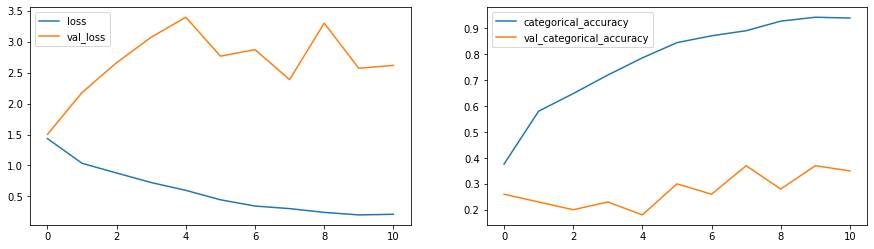

In [19]:
plot(history_model8)

Using the CNN-LSTM model, we get a somewhat better validation accuracy of 35%
But overfitting is still there. 

## Data Augmentation

Let's apply some data augmentation & check the model performance.

In [20]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

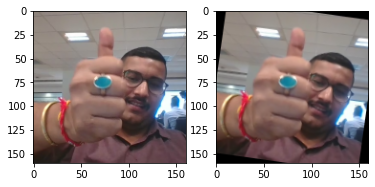

In [21]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

## Model No. 9 with Data Augmentation


####  Reducing network parameters again similar to model 7

In [42]:
class Conv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [43]:
conv_3d14=Conv3D9()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_9 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 8, 60, 60, 32)    

In [44]:
print("Total Params:", conv_3d14_model.count_params())
history_model9=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 504709
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.7836 - categorical_accuracy: 0.3424
Epoch 00001: saving model to model_init_2021-06-2809_32_01.525273/model-00001-1.78363-0.34238-1.83101-0.21000.h5
34/34 [==============================] - 146s 4s/step - loss: 1.7836 - categorical_accuracy: 0.3424 - val_loss: 1.8310 - val_categorical_accuracy: 0.2100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1784 - categorical_accuracy: 0.5422
Epoch 00002: saving model to model_init_2021-06-2809_32_01.525273/model-00002-1.17835-0.54223-2.78194-0.17000.h5
34/34 [==============================] - 143s 4s/step - loss: 1.1784 - categorical_accuracy: 0.5422 - val_loss: 2.7819 - val_categorical_accuracy: 0.1700
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9798 - categorical_accuracy: 0.6237
Epoch 00003: saving model to model_init_2021-06-2809_32_01.525273/model-00003-0.97976-0.62368-3.22238-0.19000.h5
34/34 [=======

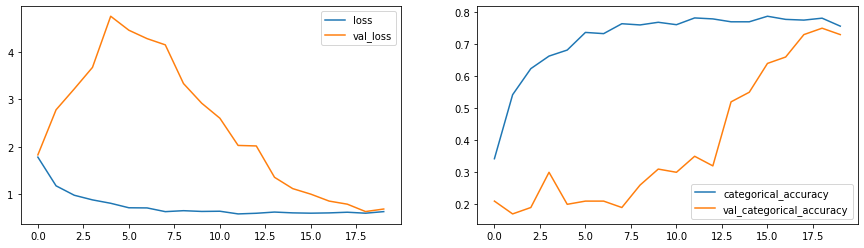

In [45]:
plot(history_model9)

We see the very good improvement in the model. 
Model start learning better from 15th epochs

- Accuracy - 75
- Validation Accuracy - 73%

Network took 17 epochs to converge. If we train model for more epoch, we may achieve very good resuld. 

## Model No. 10 with Data Augmentation


#### CNN LSTM with GRU similar to Model 8

In [46]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [47]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 18, 30, 30, 64)   

In [48]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model10=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3923 - categorical_accuracy: 0.4163
Epoch 00001: saving model to model_init_2021-06-2810_18_33.481990/model-00001-1.39232-0.41629-1.61735-0.18000.h5
34/34 [==============================] - 155s 5s/step - loss: 1.3923 - categorical_accuracy: 0.4163 - val_loss: 1.6173 - val_categorical_accuracy: 0.1800
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9382 - categorical_accuracy: 0.6335
Epoch 00002: saving model to model_init_2021-06-2810_18_33.481990/model-00002-0.93823-0.63348-1.89250-0.16000.h5
34/34 [==============================] - 158s 5s/step - loss: 0.9382 - categorical_accuracy: 0.6335 - val_loss: 1.8925 - val_categorical_accuracy: 0.1600
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7220 - categorical_accuracy: 0.7315
Epoch 00003: saving model to model_init_2021-06-2810_18_33.481990/model-00003-0.72205-0.73152-2.10178-0.21000.h5
34/34 [======

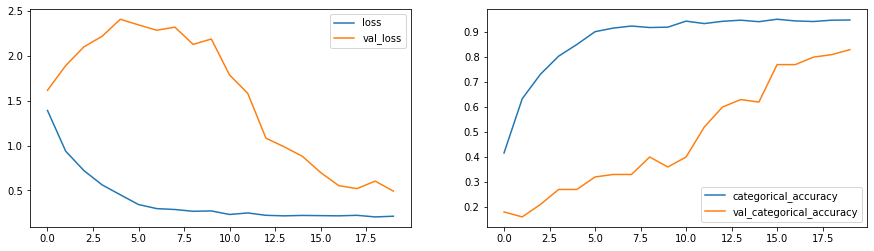

In [49]:
plot(history_model10)

This can be out second best model. This also required to train for more epochs. 

- Accuracy - 94%
- Validation Accuracy - 83%



Overall Findings:

After the experiments, we finalized Model 9 - Conv3D9, which performed well.
__Reason:__

- (Training Accuracy : 75%, Validation Accuracy : 73%)

- Number of Parameters(504,709)less according to other models performance

- Learning rate gradually decreacing after 13 Epoch


The best weights of CNN-LSTM: model-00020-0.63470-0.75641-0.68945-0.73000.h5 (6.2 MB). we considered this weight for model testing

#### 2nd Best model is: MOdel 10 - RNNCNN2 model

Lets try prediction using Conv3D9 model. 

Note:- We can have a trade off between these models if we train it for more epochs. 

# Loading model and Making the Prediction

In [50]:
import time
from tensorflow.keras.models import load_model
model = load_model('model_init_2021-06-2809_32_01.525273/model-00020-0.63470-0.75641-0.68945-0.73000.h5')

In [51]:
test_generator=RNNCNN1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [53]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[2 0 2 1 0 1 0 2 4 0 4 1 4 3 4 1 1 4 0 3]
